# Assigment 04: Due 9/30

You can use these imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit #simpliest scipy fitting method
import scipy.special as sf
import math
%matplotlib notebook

# Problem 1a

Using Monte Carlo techniques discusses in *02_Integration_MC* notebook, solve the following integral and compare it to the exact solution:

$\int_0^2 \frac{2}{(2^2 + x^2)^{3/2}}dx$

In your Monte Carlo integration, use 10,000 random points.

In [2]:
N = 10000
x0 = 0
x1 = 2

def f(x):
    return 2/((2**2+x**2)**(3/2))
x = np.linspace(x0,x1,N)
y = f(x)
fmax = max(y)

np.random.seed(0)
x_rand = x0 + (x1-x0)*np.random.random(N)
y_rand = np.random.random(N)*fmax
ind_below = np.where(y_rand < f(x_rand))
ind_above = np.where(y_rand >= f(x_rand))

ratio = float(len(ind_below[0])/N)
area = (x1-x0)*fmax
mc_integral = ratio*area
print('MC Integral:',mc_integral)

MC Integral: 0.3553


In [3]:
exact_sol = 1/(2*math.sqrt(2))
print('The Monte Carlo integration solution is a bit different than the actual solution for this integral.'
      ' The magnitude and sign of the difference depends on the random numbers generated.'
      '\n\nActually Solution',exact_sol,
      '\nMC Integral',mc_integral,
      '\nNumerical Difference:',round(mc_integral-exact_sol,6),
      '\nPercent Difference:',round(((mc_integral-exact_sol)/exact_sol),6)*100,'%')

The Monte Carlo integration solution is a bit different than the actual solution for this integral. The magnitude and sign of the difference depends on the random numbers generated.

Actually Solution 0.35355339059327373 
MC Integral 0.3553 
Numerical Difference: 0.001747 
Percent Difference: 0.494 %


# 1b

Make a scatter plot of points below and above the integrand function. This is the some type of graph shown in the *02_Integration_MC* notebook with the blue and green points.

<IPython.core.display.Javascript object>


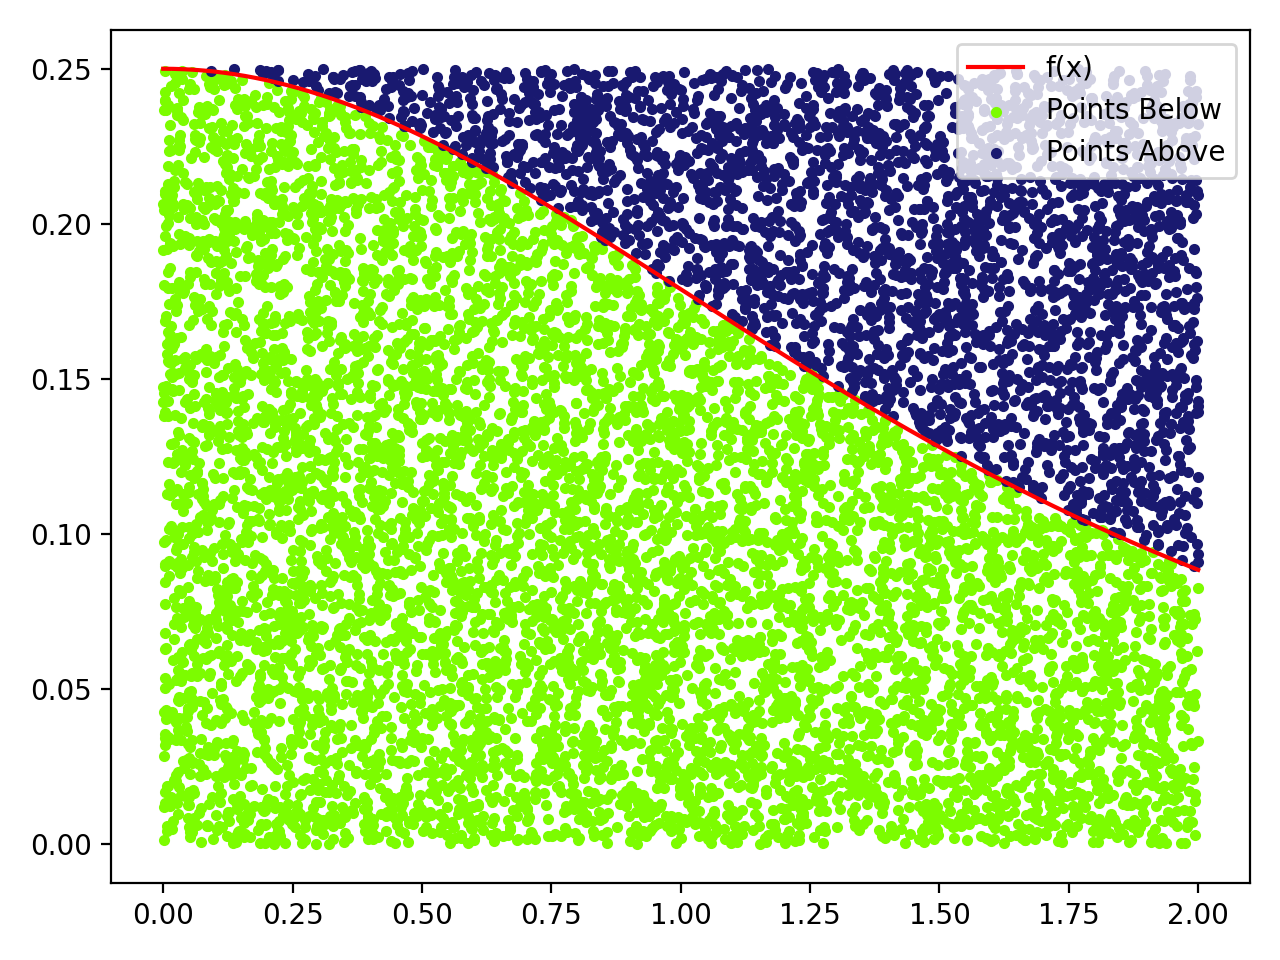

In [4]:
fig = plt.figure('MC Integration')
plt.scatter(x_rand[ind_below],y_rand[ind_below],color = "lawngreen",marker = '.',label='Points Below')
plt.scatter(x_rand[ind_above],y_rand[ind_above],color = "midnightblue",marker = '.',label = 'Points Above')
plt.plot(x,y,color = "red",label= 'f(x)')
plt.legend(loc='best')
plt.tight_layout();

# Problem 2a
Read in the data set *./data/decay_data.txt*, this lists the time in days, number of particles, and the uncertianty on the particles. This is the same radio active decay data set used in our fitting example *Fitting_Lecture_Notes* from Module 2b.

Plot the data with its error bars.


<IPython.core.display.Javascript object>


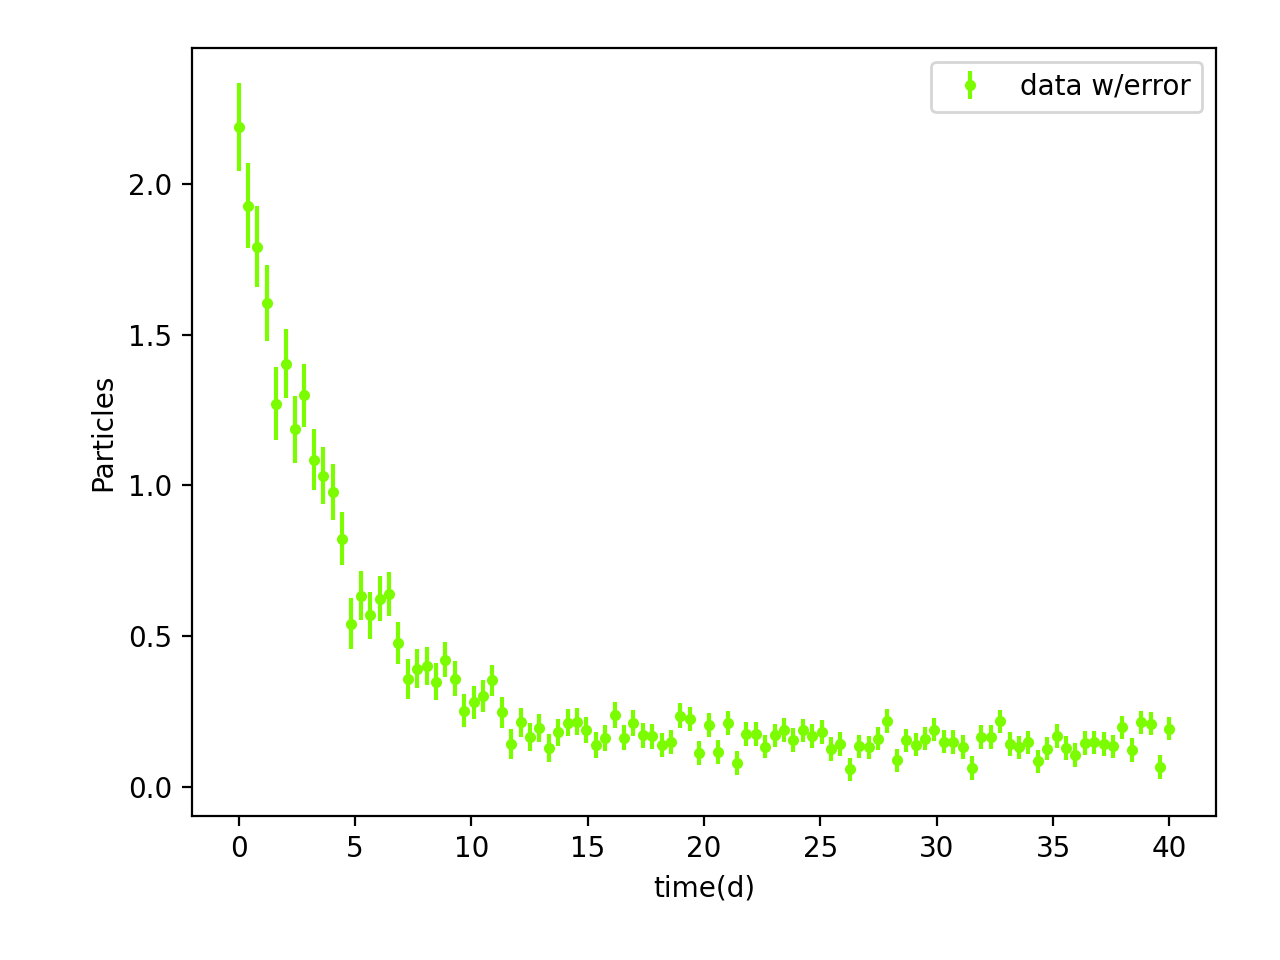

In [5]:
t,N,N_error = np.loadtxt('data/decay_data.txt', unpack=True)
fig = plt.figure('Decay Data')
axes = fig.add_axes([0.15,0.15,0.8,0.8])
axes.errorbar(t, N, yerr = N_error,fmt='.',color ='lawngreen',label='data w/error')
axes.set_xlabel('time(d)')
axes.set_ylabel('Particles')
plt.legend(loc='best');

# Problem 2b

Fit the data with 3 fit parameters using MCMC MH algorithm. You should take 10,000 steps and impliment the random test on $\chi ^2$, like we did our *03_MC_Fit* example notebook using the *get_chi_squared* function. For this we will use a function template of: $y = p_0 \cdot e^{-t/p_1} + p_2$,

where $p_0, p_1$, and $p_2$ are the fit parameters. When fitting you should choose starting values of $p_0 = p_1 = p_2 = 1.0$ to avoid nan errors.

In [6]:
def get_chi_squared(t,N,N_error,params):
    RR = 0.0
    for i in range(len(t)):
        y_prime = (params[0]*(np.exp(-t[i]/params[1])))+params[2]
        RR = RR + ((N[i] - y_prime)/N_error[i])**2
    return RR

In [7]:
np.seterr(all = 'ignore')
steps = 10000
init_par = np.array([1.0,1.0,1.0])
par_list, RRs = [init_par], [get_chi_squared(t, N, N_error, init_par)]
for i in range(steps):
    test_par = [np.random.normal(par_list[-1][0],0.5),np.random.normal(par_list[-1][1],0.5),np.random.normal(par_list[-1][2],0.5)]
    RR_test = get_chi_squared(t,N,N_error,test_par)
    bol = (np.random.random() <= (RRs[-1])/RR_test)
    if bol:
        par_list.append(test_par)
        RRs.append(RR_test)
    else:
        par_list.append(par_list[-1])
        RRs.append(RRs[-1])

In [8]:
np.random.seed(0)
RR_min = np.amin(RRs) 
chisq = RR_min
best_i = RRs.index(RR_min)
best_pars = par_list[best_i]
print("best m =",best_pars[0],'\nbest b =',best_pars[1],'\nchi2 =',RR_min,'\nindex =', best_i)      

best m = 1.7865047026200753 
best b = 4.379018828050424 
chi2 = 129.1452902991237 
index = 82


# Problem 2c

What is the reduced $\chi^2$ of your fit and the p-value?
Is this a good fit?

In [9]:
dof = len(t) - len(init_par) - 1
pvalue = sf.gammaincc(dof/2.0, chisq/2.0)
print('chi2 =',chisq,'\ndof =',dof,'\nreduced chi2 = ',chisq/dof,'\np-value =',pvalue,
      '\n\nThis is a good fit because when testing the p-value at a 0.01 (alpha) level of signifigance, we notice that '
       'the p-value is greater than the significance level threshold. This entails us to accept the null hypothesis.')

chi2 = 129.1452902991237 
dof = 96 
reduced chi2 =  1.3452634406158719 
p-value = 0.013604086901662222 

This is a good fit because when testing the p-value at a 0.01 (alpha) level of signifigance, we notice that the p-value is greater than the significance level threshold. This entails us to accept the null hypothesis.


# Problem 2d

Plot on the same graph your data and the line showin the fitted function.

<IPython.core.display.Javascript object>


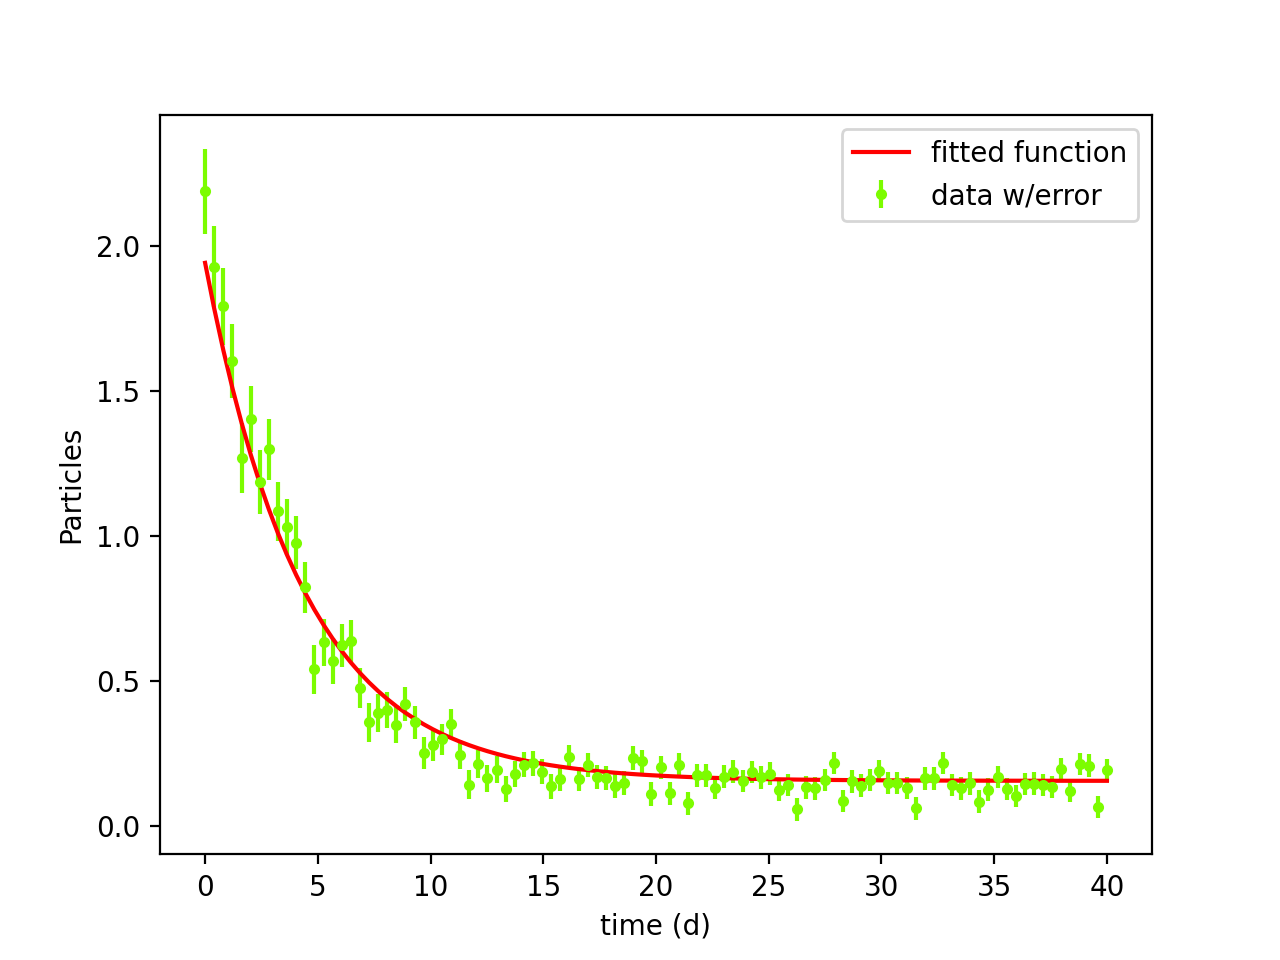

In [10]:
def guassian_func(t,p0,p1,p2): 
    return (p0*(np.exp(-t/p1)))+p2
fig = plt.figure('Fitted Decay Data')
plt.errorbar(t,N,N_error,fmt='.',color='lawngreen',label='data w/error')
plt.plot(t,guassian_func(t,*best_pars),'red',label='fitted function')
plt.xlabel('time (d)')
plt.ylabel('Particles')
plt.legend(loc='best');

# Problem 2e

Plot the histogram distributions of the three fit parameters.

<IPython.core.display.Javascript object>


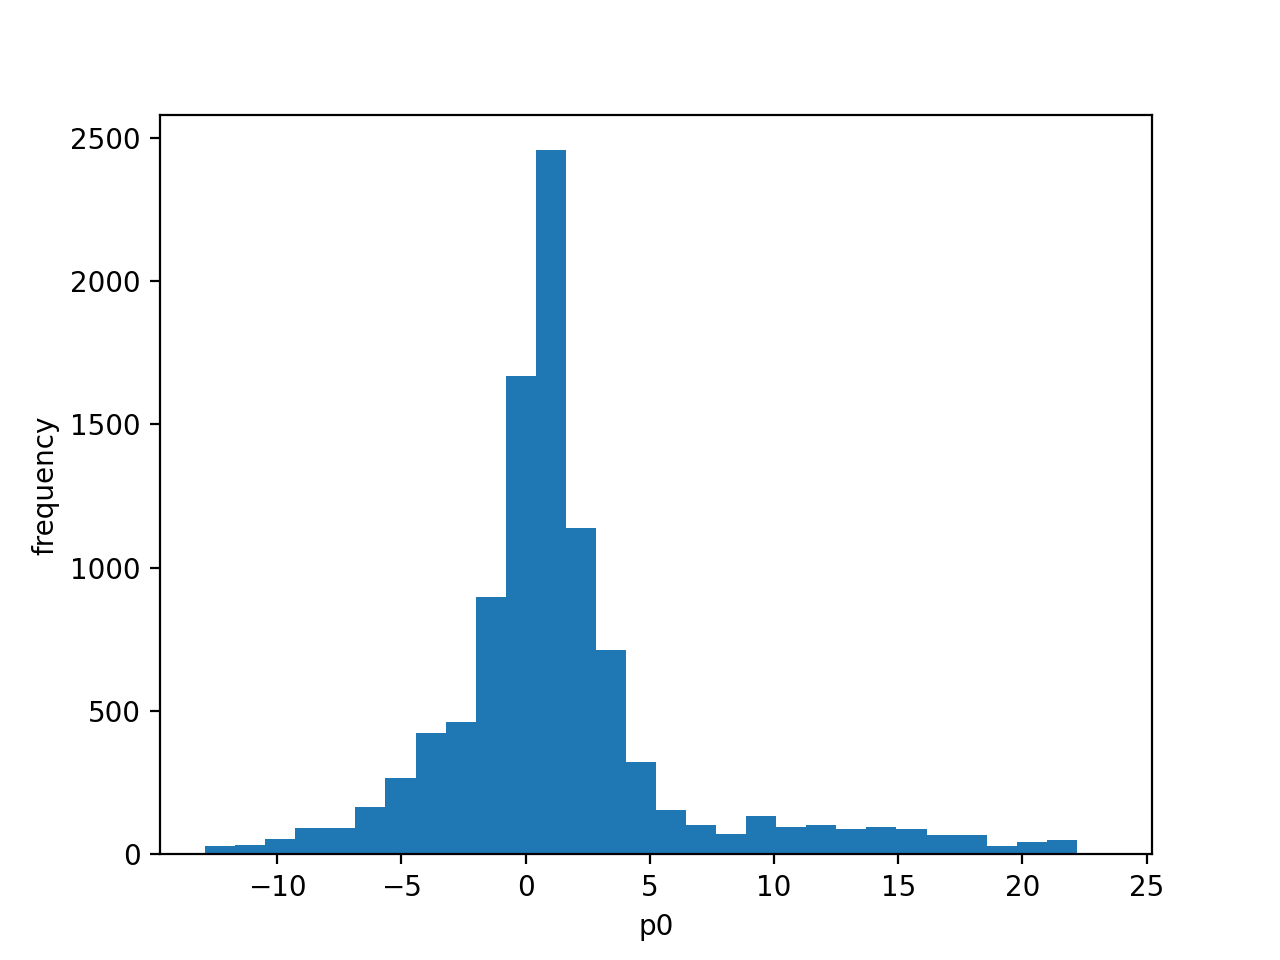

<IPython.core.display.Javascript object>


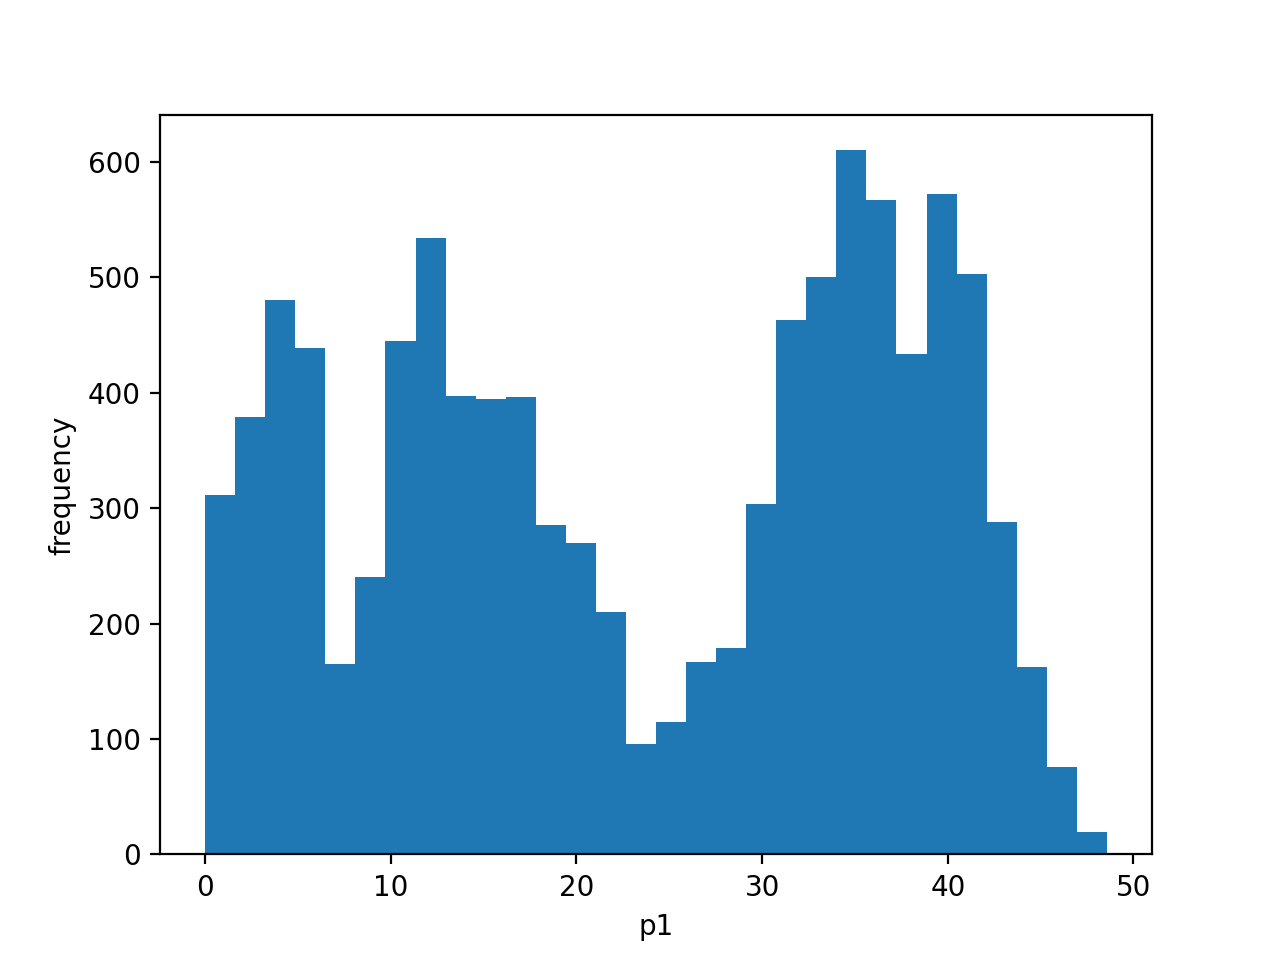

<IPython.core.display.Javascript object>


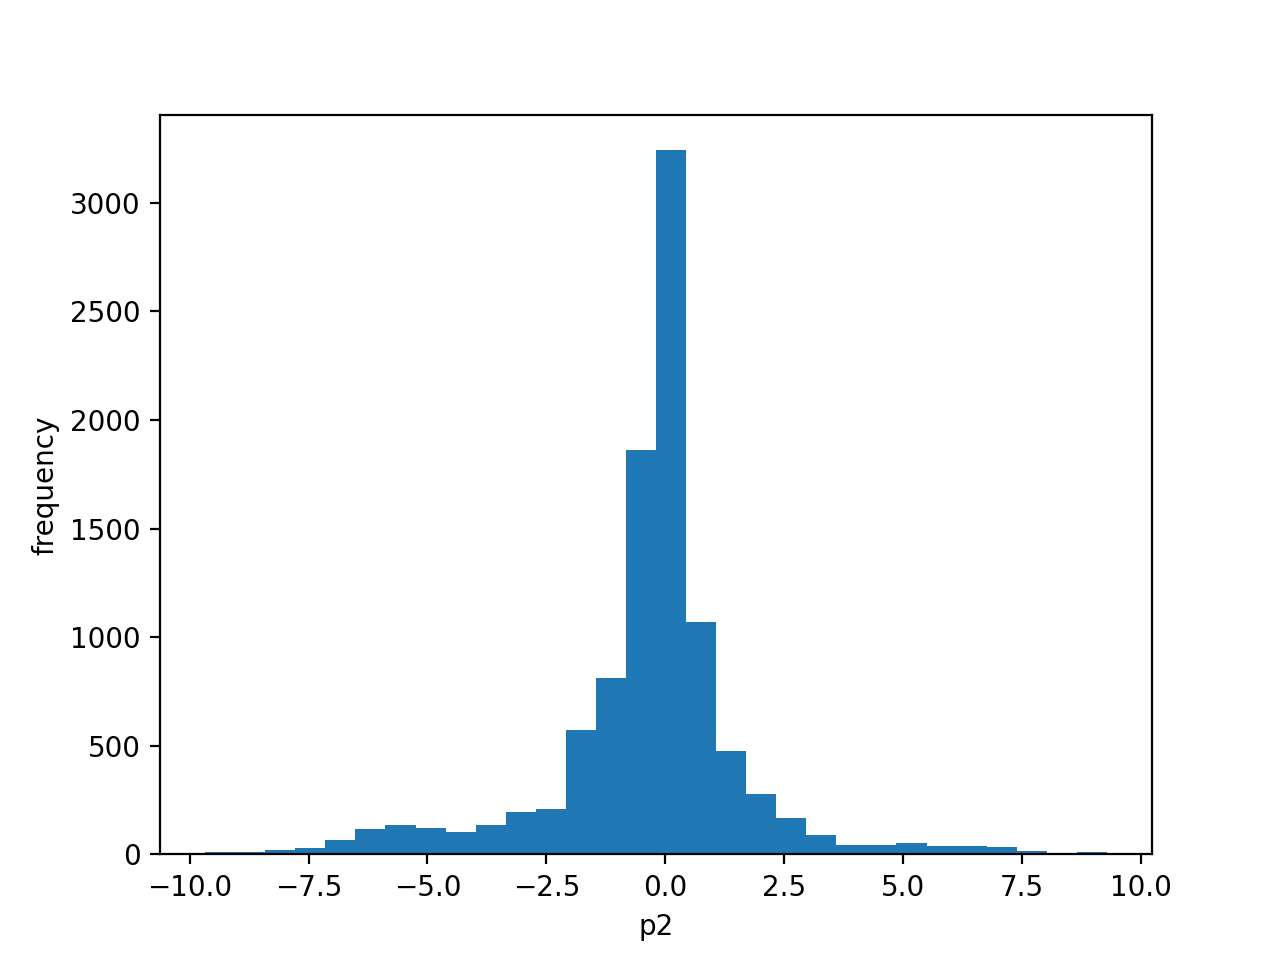

In [11]:
parameters = np.array(par_list)

hist_p0 = plt.figure('p0 frequency of occurrence')
plt.hist(parameters[:,0], bins=30)
plt.xlabel('p0')
plt.ylabel('frequency')

hist_p1=plt.figure('p1 frequency of occurrence')
plt.hist(parameters[:,1], bins=30)
plt.xlabel('p1')
plt.ylabel('frequency')

hist_p2=plt.figure('p2 frequency of occurrence')
plt.hist(parameters[:,2], bins=30)
plt.xlabel('p2')
plt.ylabel('frequency');